<a href="https://colab.research.google.com/github/mission-impozzible/learning/blob/main/time_series/2025_11_25_time_series_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series

In questo notebook voglio sporcarmi le mani con le serie temporali per capire dei punti metodologici.

Azioni selezionate:

| Ticker  | Descrizione                                                                                                                                       | Categoria        |
|---------|---------------------------------------------------------------------------------------------------------------------------------------------------|------------------|
| BTC-USD | Bitcoin in Dollari USA. Utilizzato   come principale asset di criptovaluta per l'analisi.                                                         | Criptovaluta     |
| SPY     | SPDR S&P 500 ETF Trust.   Rappresenta le performance delle 500 maggiori aziende quotate negli USA. È un proxy del mercato azionario generale.     | Indice Azionario |
| QQQ     | Invesco QQQ Trust. Rappresenta le   performance delle 100 maggiori aziende non finanziarie quotate al Nasdaq. È un proxy del settore tecnologico. | Indice Azionario |

Risorse da approfondire:
* https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

# Time series basics

## Che cos'è la Stazionarietà?
Una serie temporale si dice stazionaria se le sue proprietà statistiche, come la media e la varianza, e la sua struttura di autocovarianza, rimangono costanti nel tempo. In parole povere, significa **assenza di trend**. Solitamente le serie possono essere non stazionarie mentre i rendimenti sono tendenzialmente stazionari.

I modelli statistici classici (come ARIMA) assumono che i dati che stai analizzando siano stazionari. Modellare una serie non stazionaria direttamente può portare a previsioni inaffidabili (il fenomeno delle "regressioni spurie").

## Che cos'è l'Autocorrelazione
Un altro strumento cruciale è l'Autocorrelazione. In termini semplici, l'autocorrelazione (misurata con la Funzione di Autocorrelazione, ACF) ci dice quanto un valore corrente di una serie temporale è correlato con i suoi valori passati. Anche qui tendenzialmente i prezzi sono autocorrelati, in quanto il prezzo di ieri è molto simile al prezzo di oggi, mentre i rendimenti possono avere una bassa autocorrelazione.

# Imports

In [ ]:
%%capture
!pip install yfinance

In [ ]:
import yfinance as yf

In [ ]:
raw_data = yf.download (tickers = "BTC-USD, SPY, QQQ",
                        interval = "1d",
                        group_by = 'ticker',
                        auto_adjust = True,
                        start="2016-01-01")

raw_data.columns = ['_'.join(col).strip() for col in raw_data.columns.values]

df = raw_data.copy()

[*********************100%***********************]  3 of 3 completed


In [ ]:
df.head()

,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-USD_Volume,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume,QQQ_Open,QQQ_High,QQQ_Low,QQQ_Close,QQQ_Volume
Date,,,,,,,,,,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,36278900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,434.622009,436.062012,431.869995,433.437988,30096600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,433.578003,433.743011,424.705994,430.010986,39633800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,430.061005,434.516998,429.084015,433.091003,38477500,170.425104,170.884121,168.810015,170.875626,222353500.0,101.930186,102.069881,100.691569,101.976753,50807600.0
2016-01-05,433.069000,434.182007,429.675995,431.959991,34522600,171.198577,171.623599,170.051028,171.164581,110845800.0,102.479668,102.610049,101.324865,101.799820,38795200.0


# Data Processing

`df.asfreq('B')`: Questo metodo è usato per campionare nuovamente l'indice del DataFrame a una nuova frequenza specificata.

`'B' (o 'b')`: Questa è l'alias di frequenza standard di Pandas che sta per Business Day Frequency (Frequenza Giornaliera Lavorativa).

`df.fillna(...)`: Questo metodo è usato per sostituire i valori NaN (che abbiamo appena creato o che erano già presenti) nel DataFrame.

`method='bfill'`: Questo è il metodo di riempimento chiamato Backward Fill (Riempimento a Ritroso).

In [ ]:
import pandas as pd

def crea_metriche_finanziarie(df: pd.DataFrame, tickers: list) -> pd.DataFrame:
    """
    Crea nuove colonne nel DataFrame per prezzi di chiusura, rendimenti,
    rendimenti al quadrato e volumi per i ticker specificati.

    Args:
        df (pd.DataFrame): Il DataFrame di input contenente i dati multi-ticker.
        tickers (list): Una lista di stringhe che rappresentano i ticker da processare.

    Returns:
        pd.DataFrame: Il DataFrame modificato con le nuove colonne delle metriche.
    """

    for ticker in tickers:
        # Ticker in minuscolo per nomi colonna più semplici
        nome_breve = ticker.lower().replace('-', '_')

        # 1. Estrazione Prezzi di Chiusura
        # Esempio: df['btc_usd'] = df['Close']['BTC-USD']
        df[nome_breve] = df[f'{ticker}_Close']

        # 2. Creazione Rendimenti Percentuali (percent change)
        # Esempio: df['ret_btc_usd'] = df['btc_usd'].pct_change(1).mul(100)
        df[f'ret_{nome_breve}'] = df[nome_breve].pct_change(1).mul(100)

        # 3. Creazione Rendimenti al Quadrato (squared returns)
        # Esempio: df['sq_btc_usd'] = df['ret_btc_usd'] * df['ret_btc_usd']
        # I rendimenti al quadrato sono usati come proxy per la Volatilità/Varianza
        df[f'sq_{nome_breve}'] = df[f'ret_{nome_breve}'].mul(df[f'ret_{nome_breve}'])

        # 4. Estrazione Volume
        # Esempio: df['q_btc_usd'] = df['Volume']['BTC-USD']
        df[f'q_{nome_breve}'] = df[f'{ticker}_Volume']

    # Ritorna il DataFrame modificato
    return df

In [ ]:
TICKERS = ['BTC-USD', 'SPY', 'QQQ']

df_clean = crea_metriche_finanziarie(df.copy(), TICKERS)

df_clean = df_clean.asfreq('b')
df_clean = df_clean.fillna(method='bfill')

LIST_COLS_TO_REMOVE = []
for ticker in TICKERS:
  for label in ['Open', 'High', 'Low', 'Close', 'Volume']:
    LIST_COLS_TO_REMOVE.append(f'{ticker}_{label}')

print(LIST_COLS_TO_REMOVE)

cols_keep = [col for col in df_clean.columns if col not in LIST_COLS_TO_REMOVE]

df_clean = df_clean.filter(cols_keep)

/tmp/ipython-input-90665012.py:26: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'ret_{nome_breve}'] = df[nome_breve].pct_change(1).mul(100)
/tmp/ipython-input-90665012.py:26: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'ret_{nome_breve}'] = df[nome_breve].pct_change(1).mul(100)


['BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low', 'BTC-USD_Close', 'BTC-USD_Volume', 'SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_Volume', 'QQQ_Open', 'QQQ_High', 'QQQ_Low', 'QQQ_Close', 'QQQ_Volume']


/tmp/ipython-input-1419416261.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='bfill')


In [ ]:
df_clean.shape

(2583, 12)

In [ ]:
df_clean.columns

Index(['btc_usd', 'ret_btc_usd', 'sq_btc_usd', 'q_btc_usd', 'spy', 'ret_spy',
       'sq_spy', 'q_spy', 'qqq', 'ret_qqq', 'sq_qqq', 'q_qqq'],
      dtype='object')

# EDA

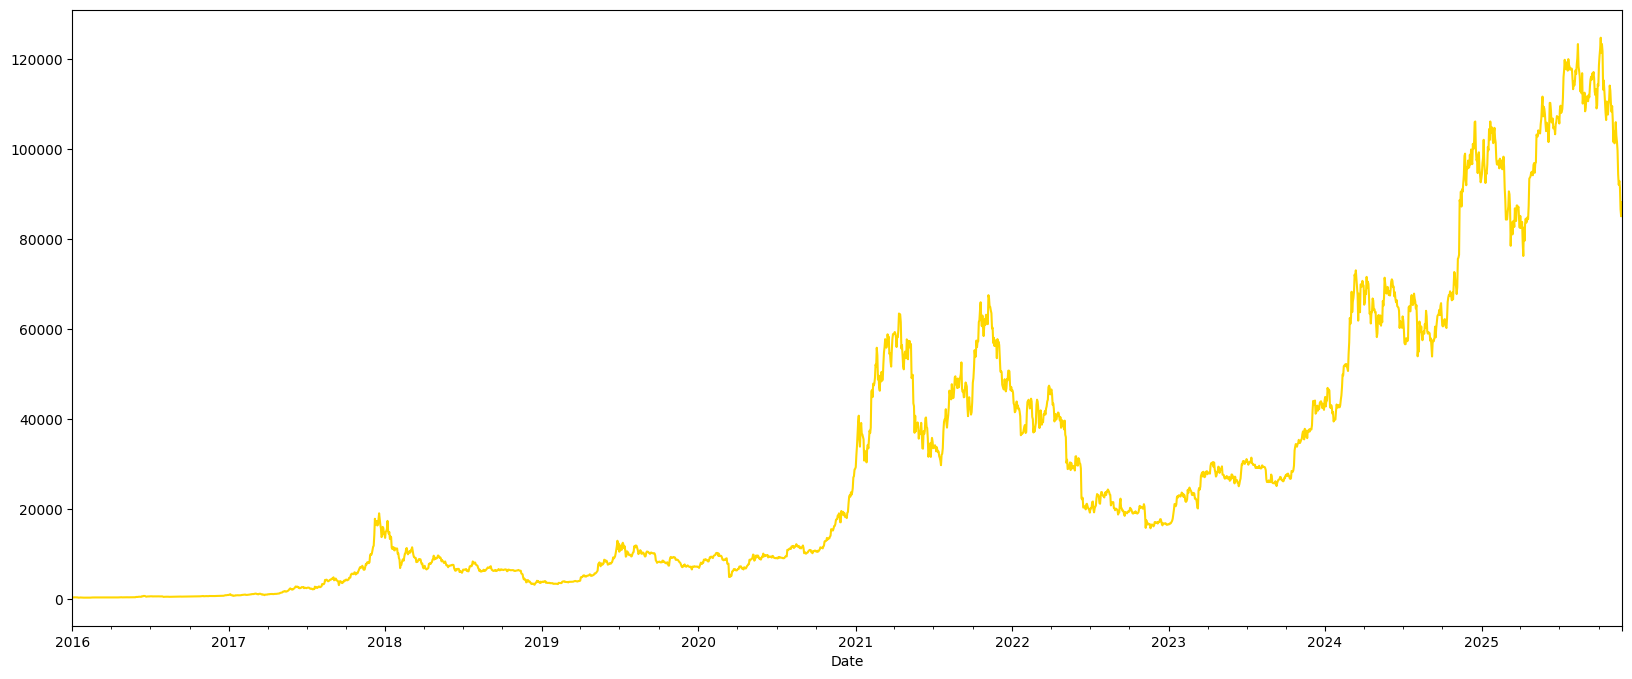

In [ ]:
import matplotlib.pyplot as plt

df_clean['btc_usd'].plot(figsize= (20,8), color = "gold")
plt.show()

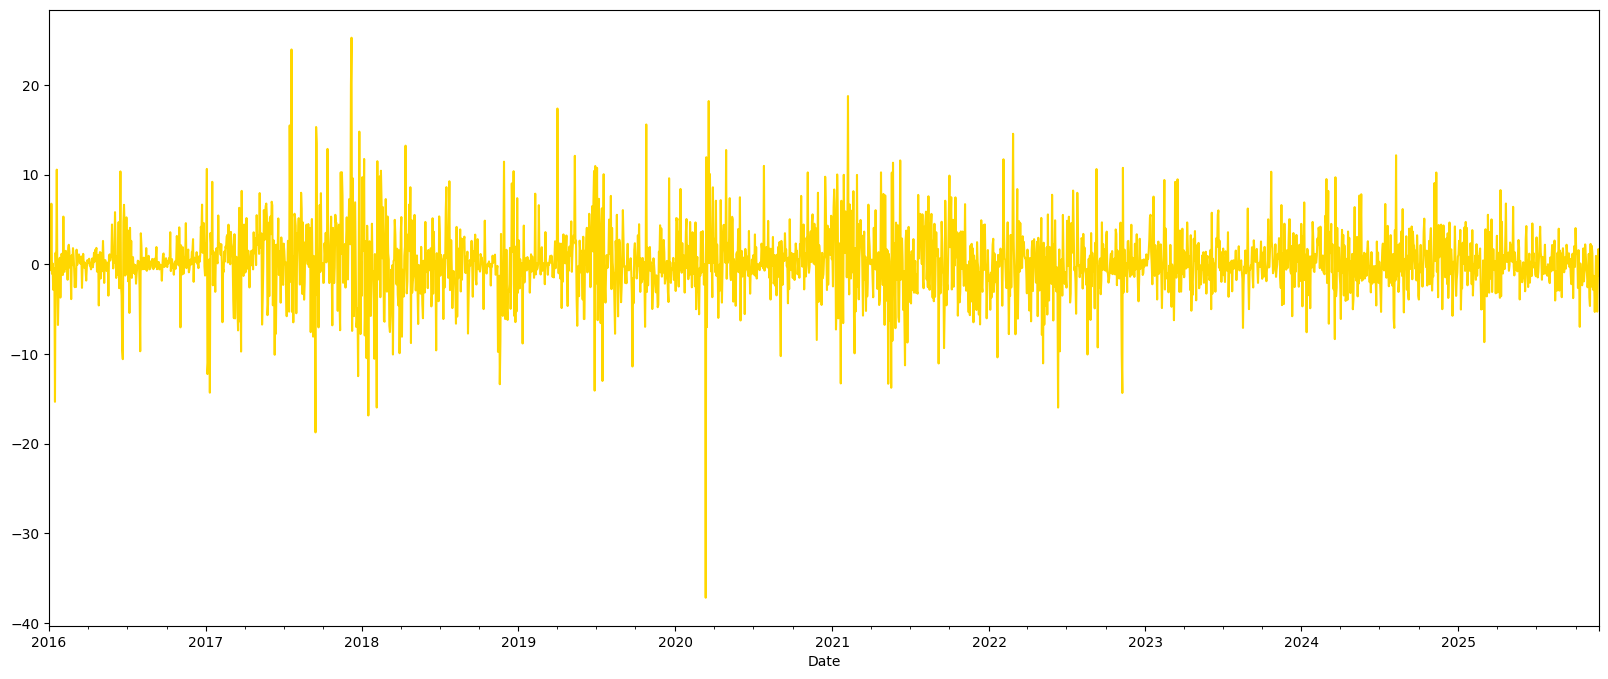

In [ ]:
df_clean['ret_btc_usd'].plot(figsize= (20,8), color = "gold")
plt.show()

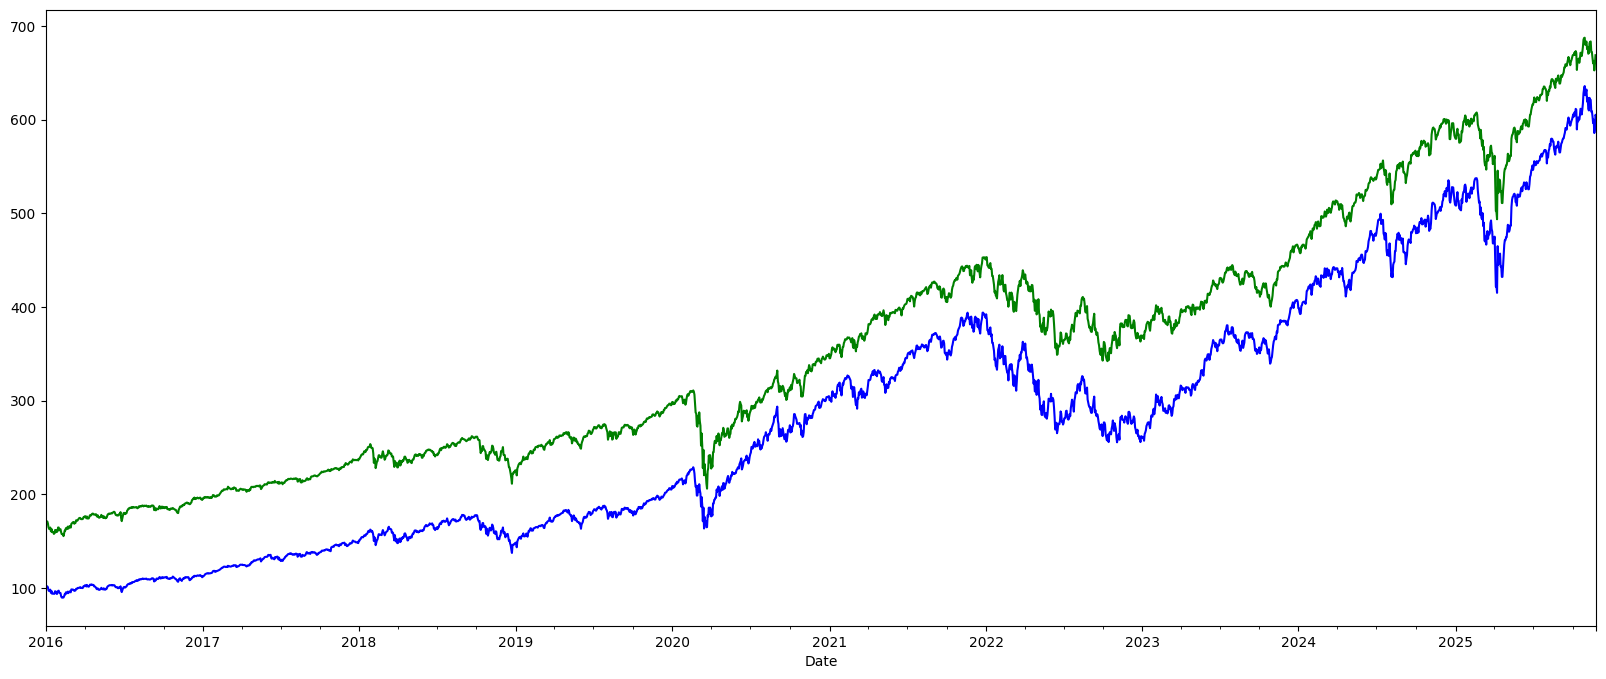

In [ ]:
df_clean['spy'].plot(figsize= (20,8), color = "green")
df_clean['qqq'].plot(color = "blue")
plt.show()

# Correlation & Autocorrelation

Il calcolo dell'autocorrelazione è analogo alla correlazione tra due variabili, solo che le due "variabili" sono in realtà la stessa serie in momenti diversi.

L'autocorrelazione è trascurabile sui rendimenti ma diventa rilevante analizzando i quadrati dei rendimenti in quanto il quadrato del rendimento ($R_t^2$) è una misura diretta della magnitudine del cambiamento, indipendentemente dalla sua direzione (positiva o negativa). I rendimenti quindi misurano la direzione del cambiamento, mentre il loro quadrato l'entità o magnitudine.

Da qui il concetto di *Efficienza Debole del Mercato*: non puoi prevedere la direzione del prezzo di domani basandoti solo sulla direzione di oggi. Mentre per i rendimenti al quadrato dimostrano una persistenza nella magnitudine del cambiamento (la volatilità) che è anche definito come *il fenomeno del Clustering della Volatilità*, e usare $R_t^2$ è il modo standard per rilevarlo e quantificarlo.

In [ ]:
print('Correlation among stocks \n')
df_clean.loc[:, ['btc_usd', 'spy', 'qqq']].corr().round(3)

Correlation among stocks 



,btc_usd,spy,qqq
btc_usd,1.000,0.941,0.941
spy,0.941,1.000,0.995
qqq,0.941,0.995,1.000


<Figure size 1200x500 with 0 Axes>

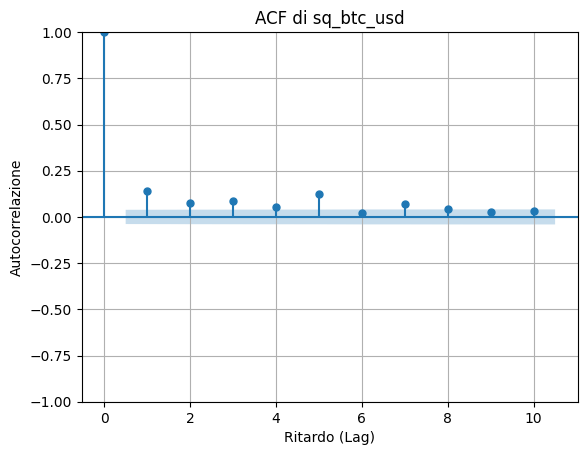


Valori di Autocorrelazione per i primi 10 ritardi:
[1.   0.14 0.07 0.09 0.05 0.12 0.02 0.07 0.04 0.02 0.03]


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

var_analysis = 'sq_btc_usd'
#var_analysis = 'ret_btc_usd'

plt.figure(figsize=(12, 5))
plot_acf(df_clean[var_analysis], lags=10, title=f'ACF di {var_analysis}')
plt.xlabel('Ritardo (Lag)')
plt.ylabel('Autocorrelazione')
plt.grid(True)
plt.show()


acf_values = acf(df_clean[var_analysis], nlags=10)
print("\nValori di Autocorrelazione per i primi 10 ritardi:")
print(acf_values.round(2))

In [20]:
%%capture
!pip install arch pmdarima

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from pmdarima.arima import auto_arima

# Modelli GARCH

**Modelli GARCH (Volatilità)**   
I modelli GARCH (*Generalized Autoregressive Conditional Heteroskedasticity*) sono stati sviluppati apposta per modellare e prevedere la volatilità dei rendimenti finanziari.

Il concetto chiave è: la varianza (volatilità) del rendimento di oggi non è costante (è eteroschedastica), ma dipende dalle informazioni passate (è condizionale).

**GARCH(1,1)**

$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$Dove:
* $\sigma_t^2$ è la volatilità condizionale (la varianza che vogliamo prevedere).
* $\epsilon_{t-1}^2$ è il rendimento al quadrato di ieri, o meglio l'errore al quadrato (la sorpresa) di ieri.
* $\omega$, $\alpha$ e $\beta$ sono i parametri che il modello stima dai tuoi dati.

Il GARCH e il Clustering:
* $\alpha$ (Reazione): Misura quanto la sorpresa di ieri (un grande rendimento, positivo o negativo) influenzi la volatilità di oggi.
* $\beta$ (Persistenza): Misura quanto la vecchia stima di volatilità (la volatilità di ieri) persista oggi.

Se $\alpha + \beta$ è vicino a 1, il cluster della volatilità è molto persistente.

# Modelli ARIMA

**Modelli ARIMA (Rendimenti)**

I modelli ARIMA (AutoRegressive Integrated Moving Average) sono usati per modellare la media condizionale della serie.
Il modello ARIMA si compone di tre parti:
* AR (AutoRegressive) - $p$: Utilizza i valori passati della serie per prevedere il valore corrente. Se $p=1$, il rendimento di oggi dipende da quello di ieri.
* I (Integrated) - $d$: Indica quante volte la serie è stata differenziata per renderla stazionaria. Visto che stiamo usando i rendimenti (che sono già la prima differenza dei log-prezzi), $d$ è quasi sempre $\mathbf{0}$.
* MA (Moving Average) - $q$: Utilizza gli errori di previsione passati (i residui) per prevedere il valore corrente.

**ARMA(1,1)**
$$R_t = c + \phi R_{t-1} + \theta \epsilon_{t-1} + \epsilon_t$$

Dove $\phi$ (phi) è l'effetto del rendimento passato e $\theta$ (theta) è l'effetto dell'errore passato.

L'uso di auto_arima è particolarmente intelligente perché evita di dover stimare e confrontare manualmente decine di combinazioni di parametri $p$, $d$, e $q$. La libreria fa tutto il lavoro, cercando la configurazione che minimizza un criterio informativo (come l'AIC o il BIC).

In [18]:

model_arima = ARIMA(df_clean['ret_btc_usd'], order=(1, 0, 1))
results_arima = model_arima.fit()

print("--- Risultati Stima ARMA(1,1) ---")
print(results_arima.summary())

# Salviamo i residui (gli errori) dell'ARMA, che useremo nel GARCH
residui = results_arima.resid

--- Risultati Stima ARMA(1,1) ---
                               SARIMAX Results                                
Dep. Variable:            ret_btc_usd   No. Observations:                 2583
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7116.557
Date:                Tue, 25 Nov 2025   AIC                          14241.114
Time:                        17:06:04   BIC                          14264.541
Sample:                    01-01-2016   HQIC                         14249.605
                         - 11-25-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2137      0.113      1.892      0.058      -0.008       0.435
ar.L1          0.9834      0.017     57.493      0.000       0.950       1.017
ma.L1         -0.9

In [25]:
model_auto_arima = auto_arima(df_clean['ret_btc_usd'],
                              m = 5, max_p = 5, max_q = 5)

print("--- Risultati Stima Auto ARIMA ---")
print(model_auto_arima.summary())


--- Risultati Stima Auto ARIMA ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2583
Model:                        SARIMAX   Log Likelihood               -7118.294
Date:                Tue, 25 Nov 2025   AIC                          14240.588
Time:                        17:27:45   BIC                          14252.301
Sample:                    01-01-2016   HQIC                         14244.833
                         - 11-25-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2220      0.075      2.963      0.003       0.075       0.369
sigma2        14.4945      0.185     78.241      0.000      14.131      14.858
Ljung-Box (L1) (Q